In [2]:
import pandas as pd
import numpy as np
import string
from string import digits
import re, copy, random, time, datetime

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.layers import Input, LSTM, Embedding, Dense, Flatten, Concatenate, Lambda
from keras.models import Model
from keras.callbacks import Callback,ModelCheckpoint, EarlyStopping
from keras.layers.core import Reshape
import keras.backend as K

Using TensorFlow backend.


In [3]:
from gensim.models import KeyedVectors
import os
from tqdm import tqdm

In [4]:
from google.colab import drive
drive.mount('/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive/


In [5]:
fil = "/gdrive/My Drive/wordvector/GoogleNews-vectors-negative300.bin.gz"

In [6]:
model = KeyedVectors.load_word2vec_format(fil, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [15]:
from google.colab import files
traind = files.upload()

Saving train.csv to train.csv


In [19]:
# lines= pd.read_csv('/gdrive/My Drive/nmt/data/train.csv', error_bad_lines=False)
lines= pd.read_csv('train.csv', error_bad_lines=False)
print(lines.shape)
# lines = lines[['utterance', 'context']]
lines = lines[['text', 'labels']]
lines.sample(10)

(105190, 2)


,text,labels
97564,i dont know but i just got two points!,1
54737,i will watch it with you!,1
64271,oh choose some one else u like not barbie,1
104001,The song title is Love You No More and it is s...,0
42337,($5.99@ W?FREE SHIPPING) CHECK IT OUT AT YOUR ...,1
98188,"that's easy to guess, he always chooses easy-t...",1
76854,Excuse me that sounds poorly please try again.,0
4769,Was there another time that this happened?,0
57736,"I agree, please email me at angelinalovegreend...",0
78627,If you are watching videos and like hip-hop mu...,0


In [20]:
lines, test = train_test_split(lines, test_size=0.98, random_state=42, shuffle=False)
lines.sample(10)

,text,labels
1093,Your mother is so overweight that she fell dow...,0
929,It's not in the word men at all.,0
581,umm a well u can't spell and ur question makes...,1
762,I have it if you would like it... message me a...,1
1674,"If needed, feel free to take baby steps.",0
362,Beer bottles or anything that make noise.,0
769,I'm hurt! I suppose the truth hurts.,0
551,I'm in love with a stripper!,0
1144,i think its his grilfriend or something like that,1
353,i thought it was really funny...espicailly the...,1


In [21]:
lines['text'] = lines['text'].apply(lambda x: x.lower())
lines['text'] = lines['text'].apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation)
lines['text'] = lines['text'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

remove_digits = str.maketrans('', '', digits)
lines['text'] = lines['text'].apply(lambda x: x.translate(remove_digits))

lines['text'] = lines['text'].apply(lambda x: x.strip())
lines['text'] = lines['text'].apply(lambda x: re.sub(" +", " ", x))

lines.drop(lines[lines['text'].str.split(' ').map(len) > 40].index, inplace=True)
lines.sample(10)

,text,labels
101,i have not heard about that though i have hear...,0
1827,i think its a partial expose but a complete pi...,1
426,i would suggest you listen to some gospel musi...,0
806,yes i certainly recall the red balloon which i...,0
28,david holmes three bar drum loops hidden track,1
966,there are three girls who came back from last ...,0
924,umm i dont know what questions u asked,1
1236,most people would like to listen to the rebel ...,0
1534,i like her and i am glad she won,0
51,perhaps it wants you to use a usb,0


In [22]:
def noise_shuffle(sent):

	sent = sent.split(' ')
	final = []
	for word in sent:
		if random.random() > 0.1:
			final.append(word)

	sent = copy.deepcopy(final)
	final = []
	k = 3
	L = len(sent)
	i = 0
	temp = []
	while i < L:
		if i+k < L:
			temp = sent[i:i+k]
			i += k
		else:
			temp = sent[i:]
			i = L
		random.shuffle(temp)
		final += temp
		temp = []

	return ' '.join(final)

In [23]:
num_syn = 1
cache = {}

In [24]:
def parse(j):
    j=j.lower()
    if j[-1] in [".",",",";","(",")"]:
        j=j[:-1]
    return j

def noise(words):
    if len(words) == 0:
      return ""
    global num_syn
    global cache
    temp = []
    s=""
    words = words.split(' ')
    for j in words:
        j = parse(j)
        try:
            try:
                temp.append(cache[j])
            except:
                #get k most similar words to query
                result = model.most_similar(positive=j, negative=[], topn=num_syn)
                temp.append(result[0][0])
                cache[j] = result[0][0]
        except:
            #if not present, duplicate word and add to list
            temp.append(j)

    # for k in temp:
    #     s.append(' '.join(map(str, k)))
    s=" ".join(map(str,temp))
    return s

In [25]:
noised_data = []
it = 0

lines.rename(columns={'text':'original'}, inplace=True)
# for sent in lines.original:
#   noised_data.append(noise(sent))
for i in tqdm(range(len(lines))):
  sent = lines.original[i]
  # it+=1
  noised_data.append(noise(sent))
  # global cache
  # if it%10000==0:
  #   cache = {}

lines['noised'] = noised_data
# lines['original'] = lines['original'].apply(lambda x : x + ' _END')

vocabulary = set()
for eng in lines.original:
    for word in eng.split():
        if word not in vocabulary:
            vocabulary.add(word)

for sent in lines.noised:
    for word in sent.split():
        if word not in vocabulary:
            vocabulary.add(word)

vocabulary.add('_END')
vocabulary.add('START_')

# lines['labels'] = lines['labels'].apply(lambda x : x.strip())
# lines['labels'] = lines['labels']
labels_set = set()
for lab in lines.labels:
	if lab not in labels_set:
		labels_set.add(lab)

lines.sample(1)


  0%|          | 0/2103 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):

100%|██████████| 2103/2103 [19:07<00:00,  1.83it/s]


,original,labels,noised
1724,rock rap news comedy sports weather traffic ch...,0,rock_n_roll hip_hop Latest_Tanker_Operator com...


In [26]:
print(labels_set, len(labels_set))
# value = 0
# max_length_src = -1
# for l in lines.noised:
# 	if len(l.split(' ')) > 40:
# 		value+=1
# 	max_length_src = max(max_length_src,len(l.split(' ')))

# max_length_tar = -1
# for l in lines.original:
# 	if len(l.split(' ')) > 40:
# 		value+=1
# 	max_length_tar = max(max_length_tar, len(l.split(' ')))
max_length_src = 40
max_length_tar = 40
# max_length_src, max_length_tar, value

{0, 1} 2


In [27]:
input_words = sorted(list(vocabulary))
num_encoder_tokens = len(vocabulary)
num_decoder_tokens = len(vocabulary) + 1
num_encoder_tokens, num_decoder_tokens

(6622, 6623)

In [28]:
token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
reverse_index = dict((i, word) for word, i in token_index.items())

lines = shuffle(lines)
lines.head(10)
len(token_index)

6622

In [29]:
labels_set = list(labels_set)
vocab_labels = dict()
for i, lab in enumerate(labels_set):
  vocab_labels[lab] = i
max_lab_len = len(labels_set)

In [30]:
X, y = list(zip(lines.noised, lines.labels)), lines.original
X_temp, X_test_temp, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train = []
X_labs = []
for a,b in X_temp:
    if b not in vocab_labels:
        print("NOO")
    X_train.append(a)
    X_labs.append(b)
X_train = np.array(X_train)
X_labs = np.array(X_labs)

X_test = []
X_labs_test = []

for a,b in X_test_temp:
    if b not in vocab_labels:
        print("NOO")
    X_test.append(a)
    X_labs_test.append(b)
X_test = np.array(X_test)
X_labs_test = np.array(X_labs_test)


def generate_batch(X = X_train, X_l = X_labs, y = y_train, batch_size = 128):
    while True:
        for j in range(0, len(X), batch_size):
            encoder_label_data = np.zeros((batch_size, 1),dtype='float32')
            encoder_label_data2 = np.zeros((batch_size, 1),dtype='float32')
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar+1, num_decoder_tokens),dtype='float32')
            decoder_target_data2 = np.zeros((batch_size, max_length_tar+1, num_decoder_tokens),dtype='float32')
            
            for i, (input_text, lab, target_text) in enumerate(zip(X[j:j+batch_size], X_l[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = token_index[word]
                encoder_label_data[i, 0] = vocab_labels[lab]
                encoder_label_data2[i, 0] = random.randint(0, len(vocab_labels))
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = token_index[word]
                    if t>=0:
                        decoder_target_data[i, t, token_index[word]] = 1
            for i in range(batch_size):
                for j in range(max_length_src):
                    decoder_target_data2[i, j] = encoder_input_data[i, j]
            decoder_target_data[i, max_length_tar, token_index['_END']] = 1
            decoder_target_data2[i, max_length_tar, token_index['_END']] = 1
            yield([encoder_input_data, encoder_label_data2, encoder_label_data, decoder_input_data], [decoder_target_data, decoder_target_data2])

In [31]:
def get_data(X=X_train, y=y_train, batch_size=128):
  random_list = random.sample(range(0,len(X)), batch_size)
  print(random_list)
  encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
  decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
  decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
  print("Yes")
  for i, j in enumerate(random_list):
      print('Yes')
      input_text = X[j]
      print('Yes')
      target_text = y[j]
      print(input_text, target_text, j)
      for t, word in enumerate(input_text.split()):
          encoder_input_data[i, t] = token_index[word]
      for t, word in enumerate(target_text.split()):
          if t<len(target_text.split())-1:
              decoder_input_data[i, t] = token_index[word]
          if t>0:
              decoder_target_data[i, t - 1, token_index[word]] = 1
              
  return encoder_input_data, decoder_input_data, decoder_target_data, random_list

In [32]:
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

In [33]:
batch_size = 32
epochs = 5
latent_dim = 128
model_path = '/gdrive/My Drive/savedmodels/nmt_weights_full_2.h5'

encoder_inputs = Input(shape=(max_length_src,))
Embeddings = Embedding(num_encoder_tokens, latent_dim, trainable=True)
enc_emb =  Embeddings(encoder_inputs)
print('Embedded Input',enc_emb.shape)

encoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]
print('Encoder lstm states',state_h.shape, state_c.shape)

encoder_inputs_temp = Input(shape=(1,))
label_Embeddings = Embedding(max_lab_len, latent_dim, trainable=True)
enc_emb1 = label_Embeddings(encoder_inputs_temp)
print('label 1 shape',enc_emb1.shape)

decoder_inputs = Input(shape=(max_length_tar,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
print('Decoded embedding shape',dec_emb.shape)

dec_emb = Concatenate(axis=1)([enc_emb1, dec_emb])

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, de_state_h, de_state_c = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


encoder_inputs_temp2 = Input(shape=(1,))
enc_emb2 = label_Embeddings(encoder_inputs_temp2)
print('label2 size',enc_emb2.shape)


print('Decoder out shape',decoder_outputs.shape)
back_data = Lambda(lambda x: K.argmax(x, axis=2))(decoder_outputs)
back_data = Lambda(lambda x : x[:,:-1])(back_data)
print('Back input shape', back_data.shape)

back_emb =  dec_emb_layer(back_data)
print('Back input embedded shape', back_emb.shape)
back_dec_emb = Concatenate(axis=1)([enc_emb2, back_emb])

back_decoder_outputs, _, _ = decoder_lstm(back_dec_emb, initial_state=[de_state_h, de_state_c])
back_decoder_outputs = decoder_dense(back_decoder_outputs)

print('Back decoded out shape',back_decoder_outputs.shape, decoder_outputs.shape, encoder_inputs.shape)
model = Model([encoder_inputs, encoder_inputs_temp, encoder_inputs_temp2, decoder_inputs], [decoder_outputs, back_decoder_outputs])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer='adam', loss=tfa.losses.TripletSemiHardLoss())

model.summary()

early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True)

training_start_time = time.time()

model.fit_generator(generator = generate_batch(X_train, X_labs, y_train, batch_size = batch_size),
                    steps_per_epoch = len(X_train)//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, X_labs_test, y_test, batch_size = batch_size),
                    validation_steps = len(X_test)//batch_size,
                    callbacks = [early_stopping, ModelCheckpoint(filepath = model_path, save_best_only = True)])

print("Training time finished.\n{} epochs in {}".format(epochs, datetime.timedelta(seconds=time.time()-training_start_time)))

Embedded Input (None, 40, 128)
Encoder lstm states (None, 128) (None, 128)
label 1 shape (None, 1, 128)
Decoded embedding shape (None, 40, 128)
label2 size (None, 1, 128)
Decoder out shape (None, 41, 6623)
Back input shape (None, 40)
Back input embedded shape (None, 40, 128)
Back decoded out shape (None, 41, 6623) (None, 41, 6623) (None, 40)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 40)   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
59/59 [==============================] - 20s 341ms/step - loss: 48705496.4746 - dense_1_loss: 48705492.0000 - dense_1_acc: 0.0056 - dense_1_acc_1: 0.0000e+00 - val_loss: 47538484.0000 - val_dense_1_loss: 46096352.0000 - val_dense_1_acc: 0.0107 - val_dense_1_acc_1: 1.2703e-04
Epoch 2/5
59/59 [==============================] - 16s 270ms/step - loss: 47976491.2203 - dense_1_loss: 47976488.0000 - dense_1_acc: 0.0108 - dense_1_acc_1: 7.7511e-05 - val_loss: 53126424.0000 - val_dense_1_loss: 43443300.0000 - val_dense_1_acc: 0.0094 - val_dense_1_acc_1: 0.0000e+00
Epoch 3/5
59/59 [==============================] - 16s 273ms/step - loss: 47945991.1441 - dense_1_loss: 47945988.0000 - dense_1_acc: 0.0107 - dense_1_acc_1: 4.6507e-04 - val_loss: 43675172.0000 - val_dense_1_loss: 42511972.0000 - val_dense_1_acc: 0.0105 - val_dense_1_acc_1: 7.6220e-04
Epoch 4/5
59/59 [==============================] - 16s 275ms/step - loss: 48009891.2797 - dense_1_loss: 48009884.0000 - dense_1_acc: 0.0113 - 

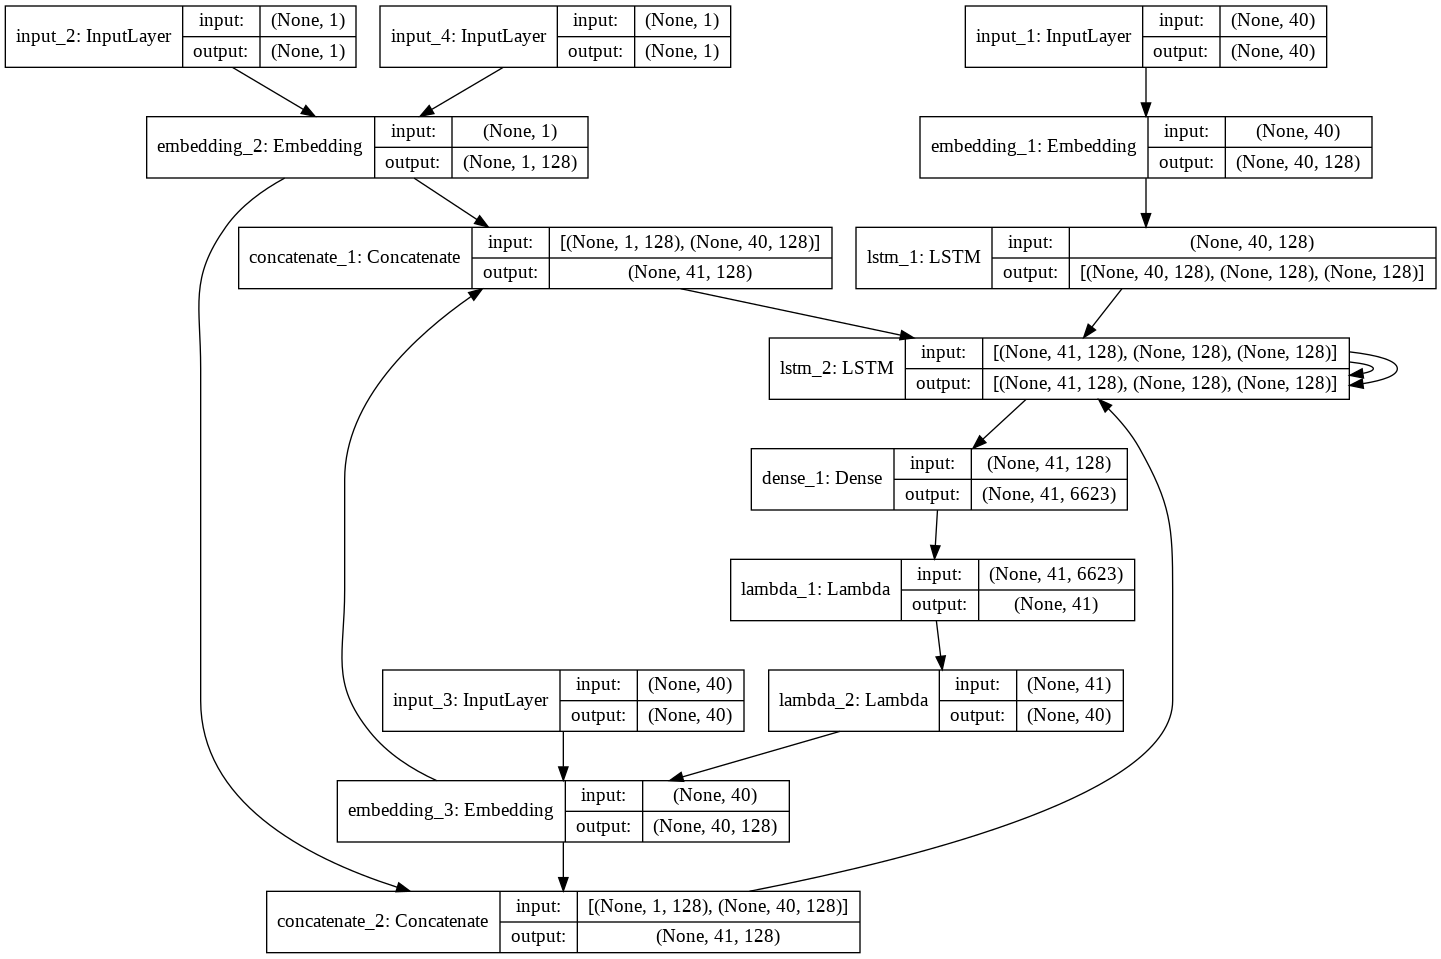

In [34]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [35]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

encoder_inputs_temp3 = Input(shape=(1,))
enc_emb3 = label_Embeddings(encoder_inputs_temp3)

dec_emb2= dec_emb_layer(decoder_inputs)
inf_emb = Concatenate(axis=1)([enc_emb3, dec_emb2])

decoder_outputs2, state_h2, state_c2 = decoder_lstm(inf_emb, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs, encoder_inputs_temp3] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [36]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    # print ("9")
    target_seq[0, 0] = token_index['START_']
    # target_seq[0, 0] = np.zeros((1,1))

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence

In [39]:
print(len(X_train), len(y_train))
input_seq, actual_output, _, indices = get_data(X_train, y_train, 1)
decoded_sentence = decode_sequence(input_seq)

k = indices[0]

print('Input English sentence:', X_train[k])
print('Actual output:', y_train[k][6:-4])
print('Predicted output:', decoded_sentence[:-4])

from nltk.translate import bleu
print(y_train[k][6:-4].split(), decoded_sentence[:-4].split())
print(bleu([y_train[k][6:-4].split()], decoded_sentence[:-4].split()))